In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import spacy  # For preprocessing
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

data = []
f = open('./marvel_films_dialogues.txt', encoding="utf-8")

#Process file and load into structure
for line in f.readlines():
    #values = line.split()
    #aa.append(values)
    if len(line) < 2:
        continue
    data.append(line[:-1])
f.close()

# cleaning data
# lemmatizing and removing the stopwords and non-alphabetic characters for each line of dialogue.
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

# removes non-alphabetic characters
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in data)

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=2000, n_threads=-1)]

df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print("df_clean's shape: ", df_clean.shape)

from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in df_clean['clean']] # split sentences to words
phrases = Phrases(sent, min_count=30, progress_per=10000)

bigram = Phraser(phrases)
sentences = bigram[sent]

# training the model
import multiprocessing
from gensim.models import Word2Vec
cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(min_count=10,
                     window=3,
                     size=300,
                     sg = 0, # default sg=0 means CBOW, sg=1 means skip-gram
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=10,
                     workers=cores-1)
w2v_model.build_vocab(sentences, progress_per=10000)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
w2v_model.init_sims(replace=True)

df_clean's shape:  (6631, 1)


WARNING - 17:39:21: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
INFO - 17:39:22: 'pattern' package not found; tag filters are not available for English
INFO - 17:39:22: collecting all words and their counts
INFO - 17:39:22: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 17:39:22: collected 16958 word types from a corpus of 21121 words (unigram + bigrams) and 6631 sentences
INFO - 17:39:22: using 16958 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 17:39:22: source_vocab length 16958
INFO - 17:39:23: Phraser built with 2 phrasegrams
INFO - 17:39:23: collecting all words and their counts
INFO - 17:39:23: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:39:23: collected 4492 word types from a corpus of 20853 raw words and 6631 sentences
INFO - 17:39:23: Loading a fresh vocabulary
INFO - 17:39:23: effective_min_count=10 retains 418 unique

INFO - 17:39:27: worker thread finished; awaiting finish of 1 more threads
INFO - 17:39:27: worker thread finished; awaiting finish of 0 more threads
INFO - 17:39:27: EPOCH - 20 : training on 20853 raw words (2092 effective words) took 0.1s, 14154 effective words/s
INFO - 17:39:27: worker thread finished; awaiting finish of 2 more threads
INFO - 17:39:27: worker thread finished; awaiting finish of 1 more threads
INFO - 17:39:27: worker thread finished; awaiting finish of 0 more threads
INFO - 17:39:27: EPOCH - 21 : training on 20853 raw words (2046 effective words) took 0.1s, 13794 effective words/s
INFO - 17:39:27: worker thread finished; awaiting finish of 2 more threads
INFO - 17:39:27: worker thread finished; awaiting finish of 1 more threads
INFO - 17:39:27: worker thread finished; awaiting finish of 0 more threads
INFO - 17:39:27: EPOCH - 22 : training on 20853 raw words (2019 effective words) took 0.2s, 11595 effective words/s
INFO - 17:39:27: worker thread finished; awaiting fi

In [7]:
w2v_model.wv.most_similar(positive='loki')

[('want', 0.7337154746055603),
 ('like', 0.7242556810379028),
 ('stark', 0.7114390134811401),
 ('hydra', 0.7064515352249146),
 ('new', 0.7025433778762817),
 ('world', 0.6969577670097351),
 ('look', 0.6947169303894043),
 ('get', 0.6934366226196289),
 ('war', 0.690983772277832),
 ('come', 0.6870323419570923)]

In [8]:
w2v_model.wv.doesnt_match(['stark', 'ultron', 'banner'])

'ultron'

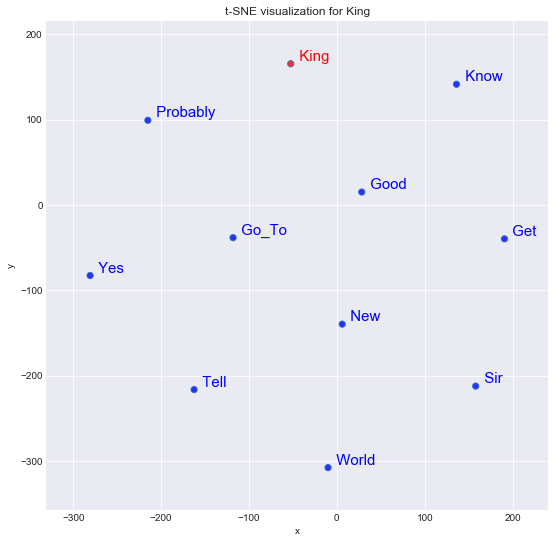

In [10]:
tsnescatterplot(w2v_model, "king", [t[0] for t in w2v_model.wv.most_similar(positive=["stark"], topn=20)][20:])